In [12]:
import pandas as pd
import re
import seaborn
from string import punctuation
from nltk.corpus import stopwords
import pymorphy2
import matplotlib.pyplot as plt
import spacy_sentence_bert
import tqdm as notebook_tqdm
from itertools import combinations
import spacy
from sentence_transformers import SentenceTransformer, util
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import datasets
import torch
from transformers import AutoTokenizer, AutoModel
import torchdata

# Load data

In [13]:
data = pd.read_csv('./DATA/Hack/train_dataset_train.csv', sep=";")
data.head()

,Исполнитель,Группа тем,Текст инцидента,Тема
0,Лысьвенский городской округ,Благоустройство,"'Добрый день. Сегодня, 20.08.22, моя мать шла ...",★ Ямы во дворах
1,Министерство социального развития ПК,Социальное обслуживание и защита,"'Пермь г, +79194692145. В Перми с ноября 2021 ...",Оказание гос. соц. помощи
2,Министерство социального развития ПК,Социальное обслуживание и защита,'Добрый день ! Скажите пожалуйста если подовал...,Дети и многодетные семьи
3,Город Пермь,Общественный транспорт,'Каждая из них не о чем. Люди на остановках хо...,Содержание остановок
4,Министерство здравоохранения,Здравоохранение/Медицина,'В Березниках у сына привитого откоронавируса ...,Технические проблемы с записью на прием к врачу


In [14]:
theme_group_classes = {j: i for i, j in enumerate(data['Группа тем'].unique())}
executors_classes = {j: i for i, j in enumerate(data['Исполнитель'].unique())}
theme_classes = {j: i for i, j in enumerate(data['Тема'].unique())}

# Предпросмотр

Рассмотрим число тем по "Группа тем"

In [15]:
theme_group_counts = data['Группа тем'].value_counts()
theme_group_counts

Группа тем
Здравоохранение/Медицина                    4673
Социальное обслуживание и защита            4626
Дороги                                      3132
ЖКХ                                         2703
Благоустройство                             2529
Мусор/Свалки/ТКО                            1735
Общественный транспорт                       869
Коронавирус                                  810
Образование                                  701
Безопасность                                 299
Связь и телевидение                          236
Мобилизация                                  134
Физическая культура и спорт                  120
Строительство и архитектура                  113
Спецпроекты                                   84
Газ и топливо                                 83
Культура                                      69
Электроснабжение                              37
Экономика и бизнес                            30
Экология                                      25
Памятники

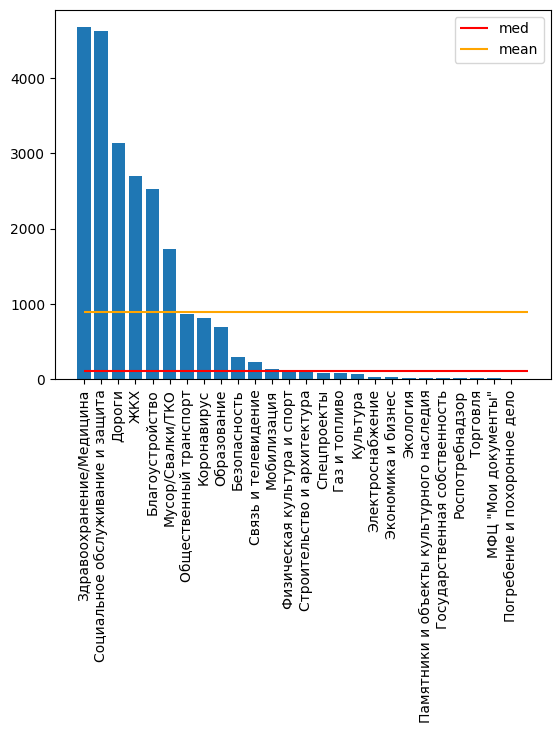

In [28]:
plt.bar(theme_group_counts.index, theme_group_counts)
plt.xticks(rotation = 90)
plt.hlines(theme_group_counts.median(), xmin=0, xmax=26, colors='r', label='med')
plt.hlines(theme_group_counts.mean(), xmin=0, xmax=26, colors='orange', label='mean')
plt.legend()
plt.show()

Рассмотрим число объектов по "Тема"

In [17]:
theme_counts = data['Тема'].value_counts()
theme_counts

Тема
Дети и многодетные семьи                                                                                           2008
Оказание гос. соц. помощи                                                                                          1886
★ Нарушение правил очистки дорог от снега и наледи/Обращения о необходимости очистить тротуар от снега и наледи    1269
Технические проблемы с записью на прием к врачу                                                                     941
★ Оказание медицинской помощи не в полном объеме/отказ в оказании медицинской помощи                                885
                                                                                                                   ... 
Выбросы вредных веществ в атмосферу/загрязнение воздуха                                                               8
Обработка и уничтожение грызунов (дератизация)                                                                        8
Установка ограждений, препятствующи

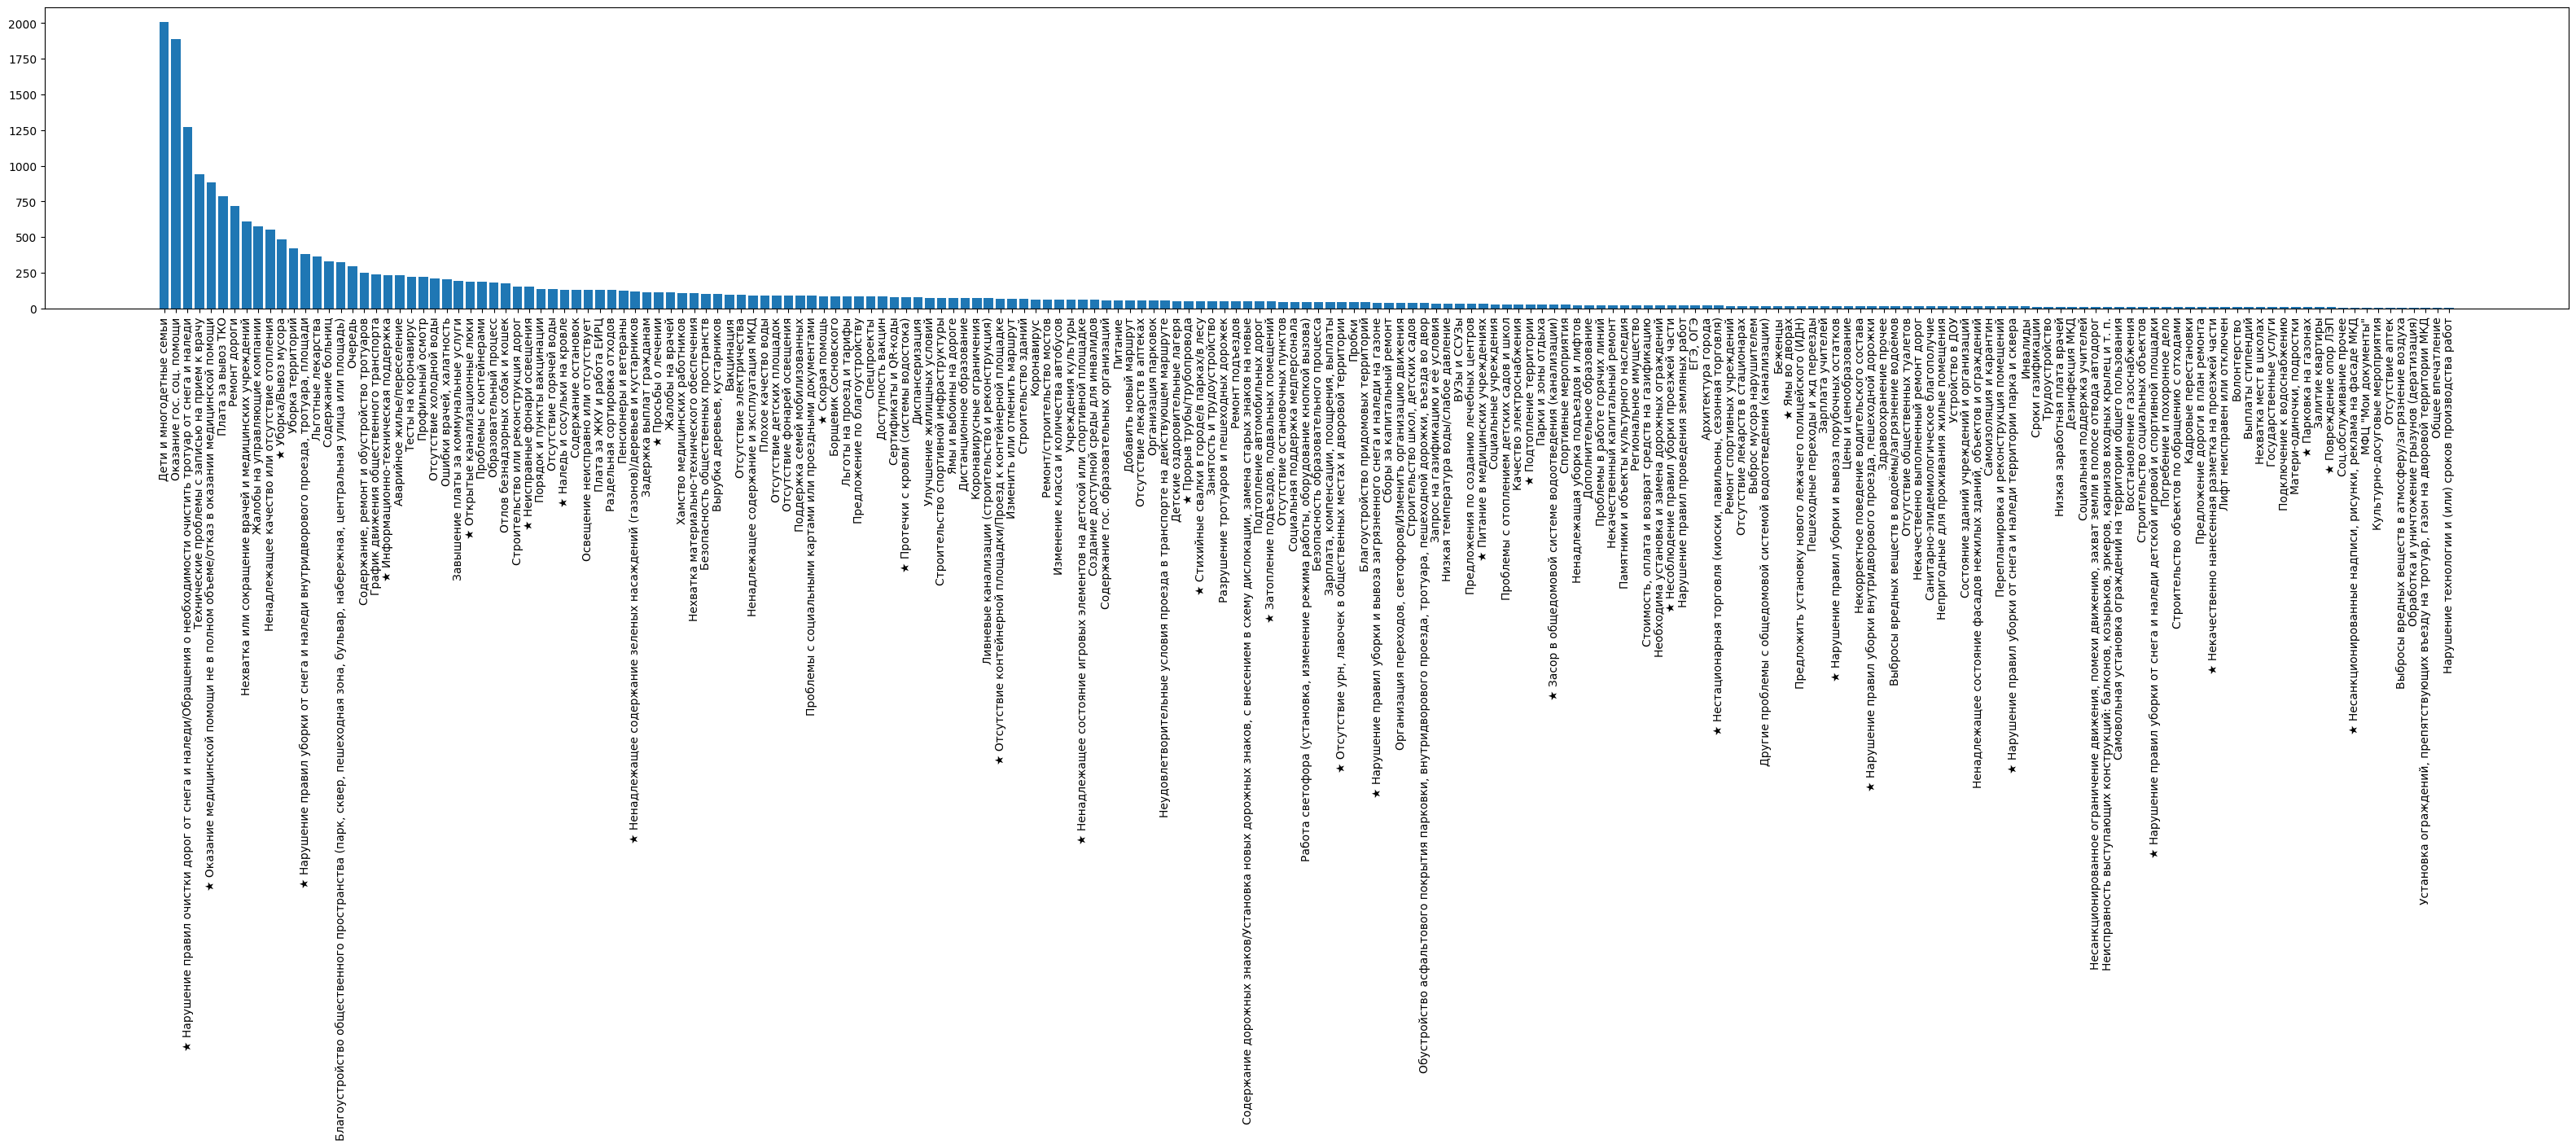

In [18]:
plt.figure().set_figwidth(40)
plt.bar(theme_counts.index, theme_counts)
plt.xticks(rotation = 90)
plt.show()

Видим, что пространство тем, по распределению, совпадает с пр-твом груп тем => можно идти по классификации от большего к меньшему

## Рассмотрим корреляцию между темами, групами тем и исполнителями 

In [19]:
data_only_class = data.drop('Текст инцидента', axis=1)
data_only_class['Исполнитель'] = data_only_class['Исполнитель'].apply(lambda a: executors_classes[a])
data_only_class['Группа тем'] = data_only_class['Группа тем'].apply(lambda a: theme_group_classes[a])
data_only_class['Тема'] = data_only_class['Тема'].apply(lambda a: theme_classes[a])

<Axes: >

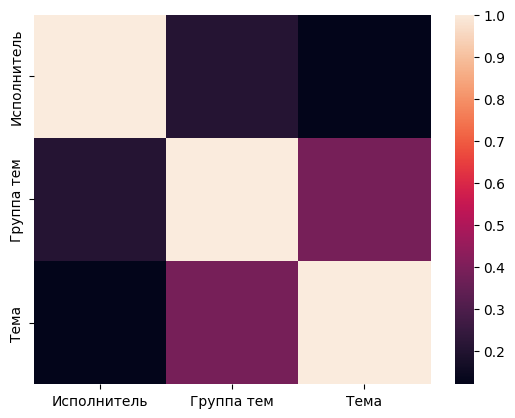

In [20]:
seaborn.heatmap(data_only_class.corr())